In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree

os.chdir("C:/Users/Hegemon/Desktop/DSA 210 Project/Veriler")

In [45]:
fire_ratio_elaborateDF = pd.read_csv("Final Form Elaborate Fire Ratio.csv")
fire_count_elaborateDF = pd.read_csv("Final Form Elaborate Fire Count.csv")
fire_count_ratio_elaborateDF = pd.read_csv("Final Form Elaborate Fire Count Ratio.csv")
weather_yearlyDF = pd.read_csv("Final Form Elaborate Yearly Weather.csv")
weather_seasonDF = pd.read_csv("Final Form Elaborate Yearly Season Weather.csv")
elaborate_fireDF = fire_ratio_elaborateDF.merge(fire_count_elaborateDF, on=["year", "country"], how="inner")
elaborate_fireDF = elaborate_fireDF.merge(fire_count_ratio_elaborateDF, on=["year", "country"], how="inner")
elaborate_yearlyDF = elaborate_fireDF.merge(weather_yearlyDF, on=["year", "country"], how="inner")
elaborate_seasonalDF = elaborate_fireDF.merge(weather_seasonDF, on=["year", "country"], how="inner")

Explained Variance
 PC  explained_variance  explained_variance_ratio  cumulative_ratio
PC1            1.871840                  0.621058          0.621058
PC2            0.867298                  0.287761          0.908819
Loadings (Contributions from PCs)
                 PC1     PC2
temp         -0.5023  0.7429
total_precip  0.6759  0.0181
wind_speed10 -0.5393 -0.6692


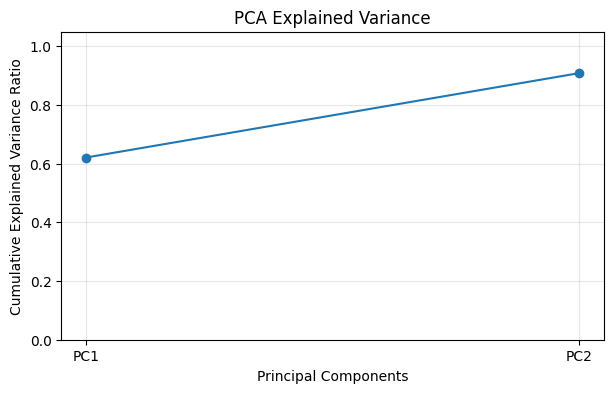

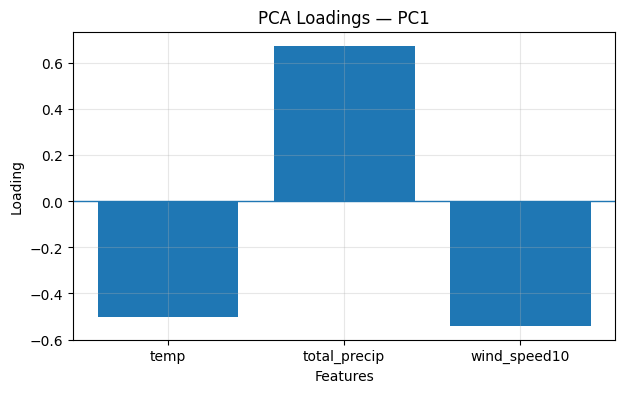

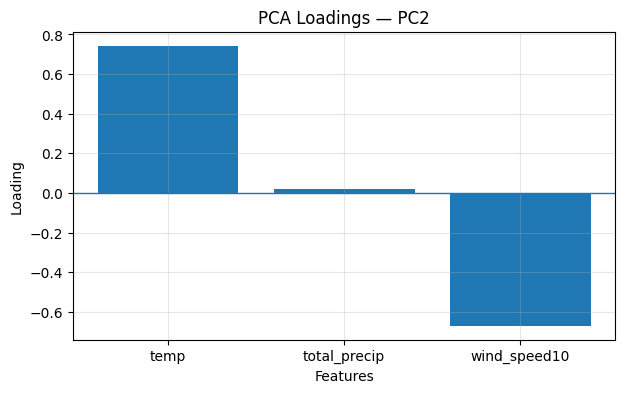

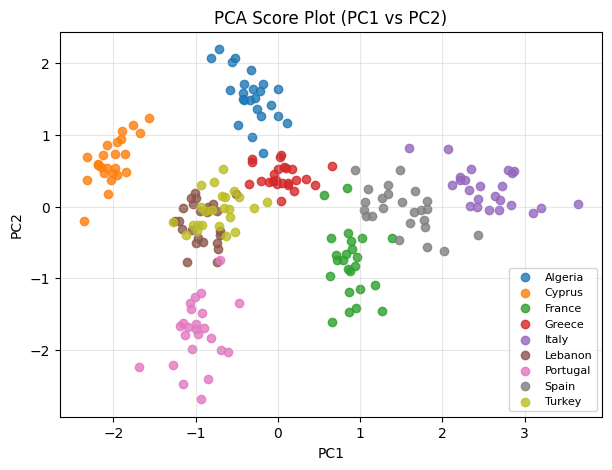

In [46]:
FEATURES = ["temp", "total_precip", "wind_speed10"]
META_COLS = ["country","year", "burned_ratio", "fire_count"]


def prepare_for_pca(df: pd.DataFrame, features=FEATURES, meta_cols=META_COLS) -> tuple[pd.DataFrame, np.ndarray, np.ndarray, StandardScaler]:
    df = df.copy()
    for c in features:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df_clean = df.dropna(subset=features).copy()
    df_clean = df_clean[np.isfinite(df_clean[features]).all(axis=1)]
    #We know that there is no NA but just to be sure. There were many occasions of hidden errors :)

    df_clean = df_clean[meta_cols + features].reset_index(drop=True) # Reset index since we will later merge some other things together
    mu = df_clean[features].mean().to_numpy()

    scaler = StandardScaler() # Standartization is standart for PCA 
    X = scaler.fit_transform(df_clean[features].to_numpy())

    return df_clean, X, mu, scaler

def run_pca(df: pd.DataFrame, features=FEATURES, meta_cols=META_COLS, n_components=2):
    df_clean, X, mu, scaler = prepare_for_pca(df, features=features, meta_cols=meta_cols)

    pca = PCA(n_components=n_components, random_state=0)
    Z = pca.fit_transform(X) 

    evr = pca.explained_variance_ratio_
    ev = pca.explained_variance_

    loadings = pd.DataFrame(pca.components_.T, index=features, columns=[f"PC{i+1}" for i in range(n_components)])

    scores = pd.DataFrame(Z, columns=[f"PC{i+1}" for i in range(n_components)])
    outDF = pd.concat([df_clean.reset_index(drop=True), scores], axis=1)

    # Explained variance df
    exp_varDF = pd.DataFrame({"PC": [f"PC{i+1}" for i in range(n_components)], "explained_variance": ev, "explained_variance_ratio": evr, "cumulative_ratio": np.cumsum(evr)})

    return {"df_clean": df_clean, "features": features, "scaler": scaler, "pca": pca, "scoresDF": outDF, "exp_varDF": exp_varDF, "loadingsDF": loadings}


def plot_explained_variance(evr_df: pd.DataFrame, title="PCA Explained Variance"):
    plt.figure(figsize=(7, 4))
    plt.plot(evr_df["PC"], evr_df["cumulative_ratio"], marker="o")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.xlabel("Principal Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.title(title)
    plt.show()


def plot_loadings(loadings_df: pd.DataFrame, title="PCA Loadings"): #Does bar plots for each PC dimension
    for pc in loadings_df.columns:
        plt.figure(figsize=(7, 4))
        plt.bar(loadings_df.index, loadings_df[pc].values)
        plt.axhline(0, linewidth=1)
        plt.grid(alpha=0.3)
        plt.xlabel("Features")
        plt.ylabel("Loading")
        plt.title(f"{title} — {pc}")
        plt.show()


def plot_scores(scores_df: pd.DataFrame, x="PC1", y="PC2", color_by="country", title="PCA Score Plot (PC1 vs PC2)"):
    plt.figure(figsize=(7, 5))
    if color_by is None:
        plt.scatter(scores_df[x], scores_df[y], alpha=0.8)
    else:
        for grp, g in scores_df.groupby(color_by):
            plt.scatter(g[x], g[y], alpha=0.8, label=str(grp))
        plt.legend(loc="best", fontsize=8)

    plt.grid(alpha=0.3)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.show()


def pca(df: pd.DataFrame, features=FEATURES, meta_cols=META_COLS, n_components=2, score_color_by="country"):
    res = run_pca(df, features=features, meta_cols=meta_cols, n_components=n_components)

    print("Explained Variance")
    print(res["exp_varDF"].to_string(index=False))

    print("Loadings (Contributions from PCs)")
    print(res["loadingsDF"].round(4))

    plot_explained_variance(res["exp_varDF"])
    plot_loadings(res["loadingsDF"])
    if n_components >= 2:
        plot_scores(res["scoresDF"], x="PC1", y="PC2", color_by=score_color_by) # Cool colours

    return res


res = pca(elaborate_seasonalDF, n_components=2, score_color_by="country")
scoresDF = res["scoresDF"]

    k  silhouette
0   2    0.470403
1   3    0.465730
2   4    0.455228
3   5    0.462166
4   6    0.521048
5   7    0.550764
6   8    0.562805
7   9    0.517770
8  10    0.504203
9  11    0.494390


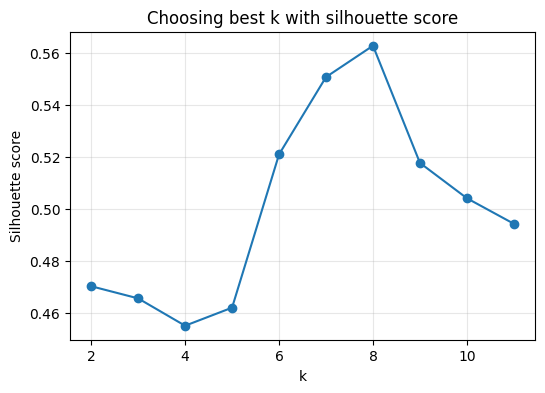

BEST K = 8
Cluster centers (PC space): [[ 1.02967466 -0.49839615]
 [-0.13951943  1.0201201 ]
 [-0.99704218 -1.80649989]
 [ 2.34053074  0.15350359]
 [-2.01718854  0.64134514]
 [-0.80280967 -0.13820351]]


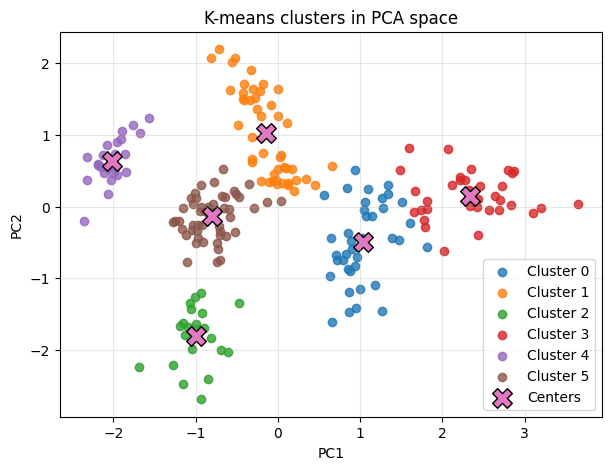

In [47]:
scoresDF = res["scoresDF"].copy()
X = scoresDF[["PC1", "PC2"]].to_numpy()

silhouette_results = []
Ks = range(2, 12) # A wide range of k

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    silhouette_results.append((k, sil))

sil_df = pd.DataFrame(silhouette_results, columns=["k", "silhouette"])
print(sil_df)

plt.figure(figsize=(6,4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Choosing best k with silhouette score")
plt.grid(alpha=0.3)
plt.show()

BEST_K = int(sil_df.loc[sil_df["silhouette"].idxmax(), "k"])
print("BEST K =", BEST_K)

kmeans = KMeans(n_clusters=6, random_state=42, n_init=20) # Even though K=8 has the best sihouette, 
#given the clusters it would just make each cluster more noisy and small while imporving by just 0.04 and making patterns more fractured. 6 seems fine

scoresDF["cluster"] = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_
print("Cluster centers (PC space):", centers)

plt.figure(figsize=(7,5))

for cl, g in scoresDF.groupby("cluster"):
    plt.scatter(g["PC1"], g["PC2"], alpha=0.8, label=f"Cluster {cl}")

plt.scatter(centers[:,0], centers[:,1], marker="X", s=200, edgecolors="black", label="Centers")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters in PCA space")
plt.grid(alpha=0.3)
plt.legend()
plt.show()



In [48]:
cluster_summary = scoresDF.groupby("cluster").agg(n=("PC1", "count"),  mean_PC1=("PC1", "mean"), mean_PC2=("PC2", "mean"), mean_temp=("temp", "mean"), mean_precip=("total_precip", "mean"), mean_wind=("wind_speed10", "mean"), mean_fire_count=("fire_count", "mean"), mean_burned_ratio=("burned_ratio", "mean"),).reset_index()

print(cluster_summary.sort_values("mean_burned_ratio", ascending=False))


   cluster   n  mean_PC1  mean_PC2  mean_temp  mean_precip  mean_wind  \
2        2  23 -0.997042 -1.806500  20.349136     0.769286   1.894600   
1        1  46 -0.139519  1.020120  23.353443     1.262535   0.890643   
4        4  24 -2.017189  0.641345  25.691614     0.013121   1.565382   
3        3  34  2.340531  0.153504  20.212084     6.669850   0.781204   
5        5  51 -0.802810 -0.138204  22.623892     0.881341   1.401085   
0        0  38  1.029675 -0.498396  19.751655     3.084968   1.043633   

   mean_fire_count  mean_burned_ratio  
2     22030.000000           4.131879  
1      1804.029412           1.409829  
4       150.583333           1.353974  
3      8796.588235           0.762155  
5      1961.222222           0.382661  
0      6903.184211           0.314550  


[RAW FEATURES] burned_ratio (Train, log-scale) Metrics
RMSE: 0.3190
MAE: 0.2197
R2: 0.6828
[RAW FEATURES] burned_ratio (Test, log-scale) Metrics
RMSE: 0.4567
MAE: 0.3109
R2: 0.2005
Best params (burned_ratio): {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 20}


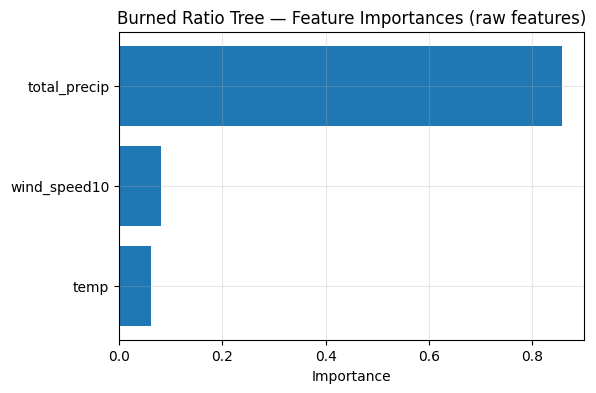

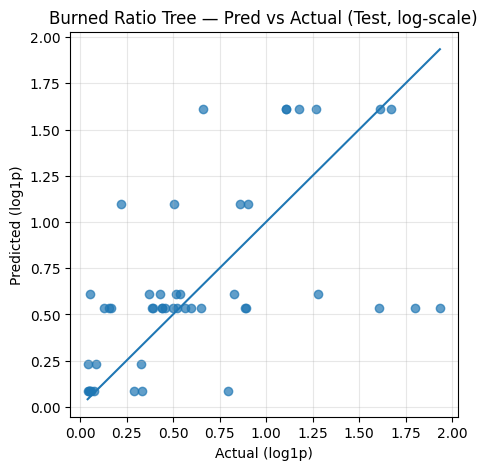

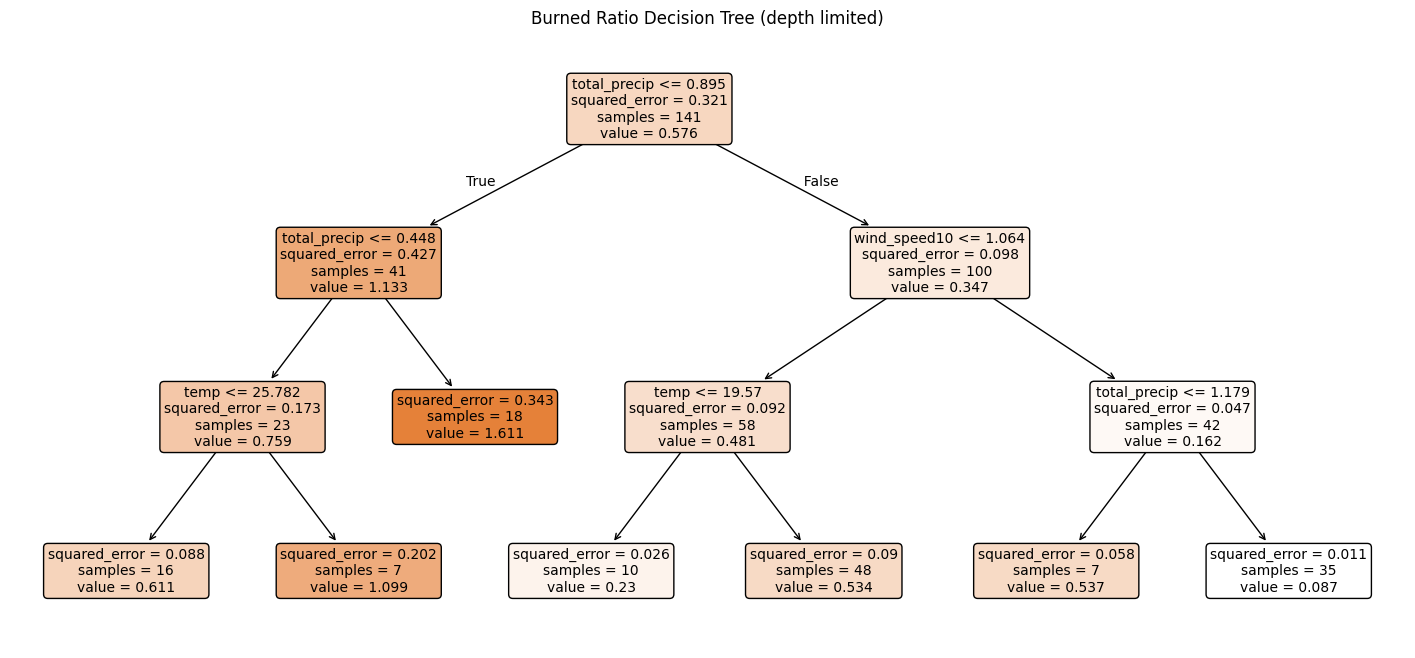

[RAW FEATURES] fire_count (Train, log-scale) Metrics
RMSE: 0.4416
MAE: 0.3440
R2: 0.9253
[RAW FEATURES] fire_count (Test, log-scale) Metrics
RMSE: 0.5899
MAE: 0.4088
R2: 0.8995
Best params (fire_count): {'max_depth': 5, 'min_samples_leaf': 12, 'min_samples_split': 10}


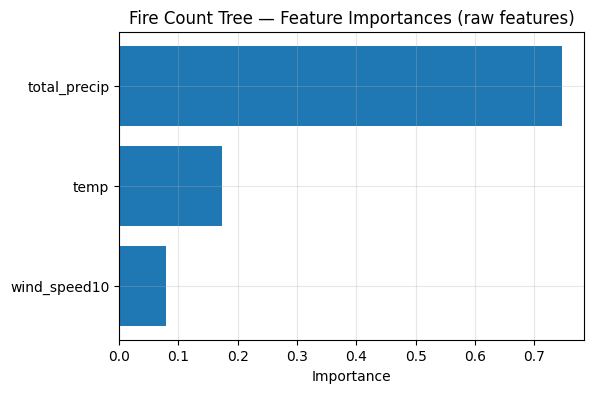

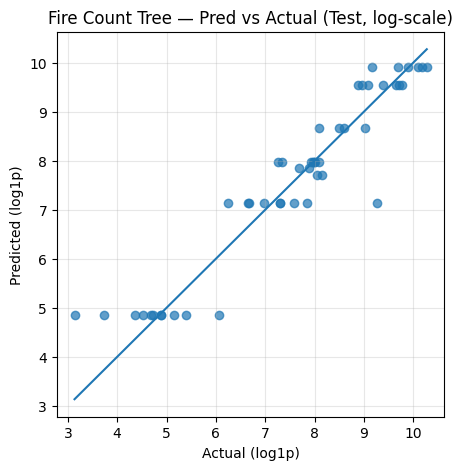

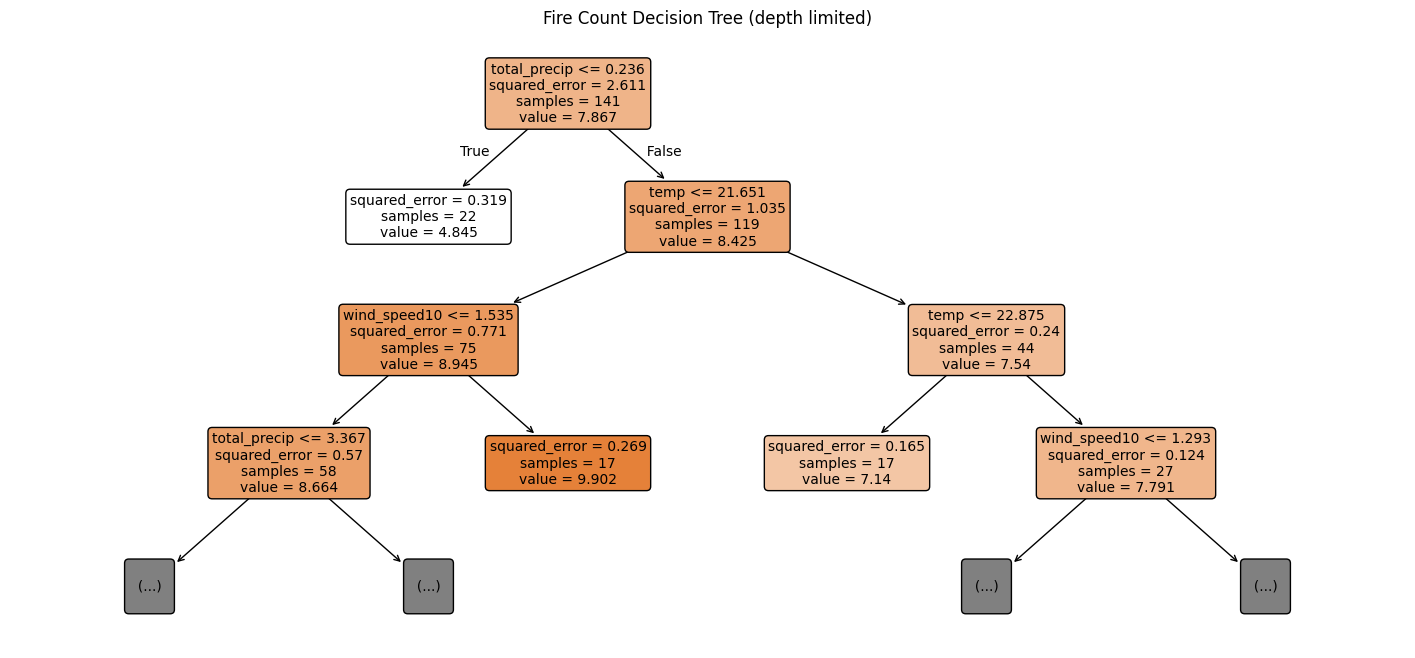

In [49]:
RAW_FEATURES = ["temp", "total_precip", "wind_speed10"]
META_COLS = ["country"]

TARGETS = {
    "burned_ratio": "burned_ratio",
    "fire_count": "fire_count"}

RANDOM_STATE = 42 # For reproducability :)


def regression_metrics(y_true, y_pred, name=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    out = {"RMSE": rmse, "MAE": mae, "R2": r2}
    if name:
        print(f"{name} Metrics")
        for k, v in out.items():
            print(f"{k}: {v:.4f}")
    return out

def make_ml_df(df: pd.DataFrame, features=RAW_FEATURES, targets=("burned_ratio", "fire_count")):
    df = df.copy()

    need = list(features) + list(targets) + META_COLS
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    for c in features + list(targets):
        df[c] = pd.to_numeric(df[c], errors="coerce")

    numcols = features + list(targets)
    df = df[np.isfinite(df[numcols]).all(axis=1)]

    df = df[(df["burned_ratio"] >= 0) & (df["fire_count"] >= 0)]

    return df.reset_index(drop=True)


def fit_tree_for_target(df: pd.DataFrame, target_col: str, features: list[str], test_size=0.25, max_depth_cap=4, title_prefix=""):

    X = df[features].to_numpy()
    y = np.log1p(df[target_col].to_numpy())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

    dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

    param_grid = {"max_depth": [2, 3, 4, 5], "min_samples_leaf": [5, 8, 12, 15], "min_samples_split": [10, 20, 30]}

    gs = GridSearchCV(dt, param_grid=param_grid, scoring="neg_root_mean_squared_error",cv=5,n_jobs=-1)
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_


    y_pred_train = best_model.predict(X_train)
    y_pred_test  = best_model.predict(X_test)

    train_metrics = regression_metrics(y_train, y_pred_train, name=f"{title_prefix}{target_col} (Train, log-scale)")
    test_metrics  = regression_metrics(y_test,  y_pred_test,  name=f"{title_prefix}{target_col} (Test, log-scale)")

    return {"features": features, "target_col": target_col, "best_params": gs.best_params_, "best_model": best_model, "X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test, "y_pred_train": y_pred_train, "y_pred_test": y_pred_test, "train_metrics": train_metrics, "test_metrics": test_metrics}


def plot_feature_importance(model: DecisionTreeRegressor, feature_names: list[str], title="Feature Importances"):
    imps = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=True)

    plt.figure(figsize=(6,4))
    plt.barh(imps.index, imps.values)
    plt.xlabel("Importance")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()


def plot_pred_vs_actual(y_true, y_pred, title="Predicted vs Actual (log-scale)"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()])
    plt.xlabel("Actual (log1p)")
    plt.ylabel("Predicted (log1p)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()


def plot_decision_tree(model: DecisionTreeRegressor, feature_names: list[str], title="Decision Tree", max_depth=3):
    plt.figure(figsize=(18, 8))
    plot_tree(model, feature_names=feature_names, filled=True, rounded=True, max_depth=max_depth, fontsize=10)
    plt.title(title)
    plt.show()


df_ml = make_ml_df(elaborate_seasonalDF, features=RAW_FEATURES, targets=("burned_ratio","fire_count"))

burn_res = fit_tree_for_target(df=df_ml, target_col="burned_ratio", features=RAW_FEATURES, title_prefix="[RAW FEATURES] ")

print("Best params (burned_ratio):", burn_res["best_params"])
plot_feature_importance(burn_res["best_model"], RAW_FEATURES, title="Burned Ratio Tree — Feature Importances (raw features)")
plot_pred_vs_actual(burn_res["y_test"], burn_res["y_pred_test"], title="Burned Ratio Tree — Pred vs Actual (Test, log-scale)")
plot_decision_tree(burn_res["best_model"], RAW_FEATURES, title="Burned Ratio Decision Tree (depth limited)", max_depth=3)

fire_res = fit_tree_for_target(df=df_ml, target_col="fire_count", features=RAW_FEATURES, title_prefix="[RAW FEATURES] ")

print("Best params (fire_count):", fire_res["best_params"])
plot_feature_importance(fire_res["best_model"], RAW_FEATURES, title="Fire Count Tree — Feature Importances (raw features)")
plot_pred_vs_actual(fire_res["y_test"], fire_res["y_pred_test"], title="Fire Count Tree — Pred vs Actual (Test, log-scale)")
plot_decision_tree(fire_res["best_model"], RAW_FEATURES, title="Fire Count Decision Tree (depth limited)", max_depth=3)


[PC FEATURES] burned_ratio (Train, log-scale) Metrics
RMSE: 0.4486
MAE: 0.3070
R2: 0.3727
[PC FEATURES] burned_ratio (Test, log-scale) Metrics
RMSE: 0.4056
MAE: 0.2826
R2: 0.3694
Best params (burned_ratio PC): {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 30}


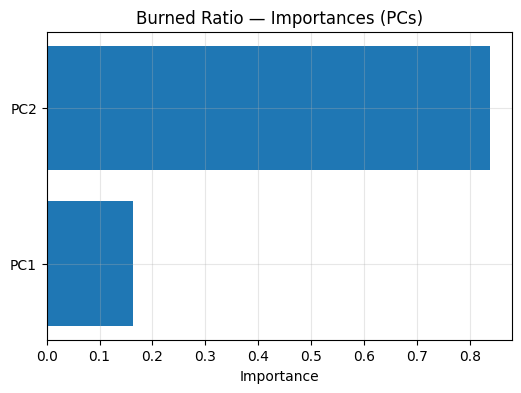

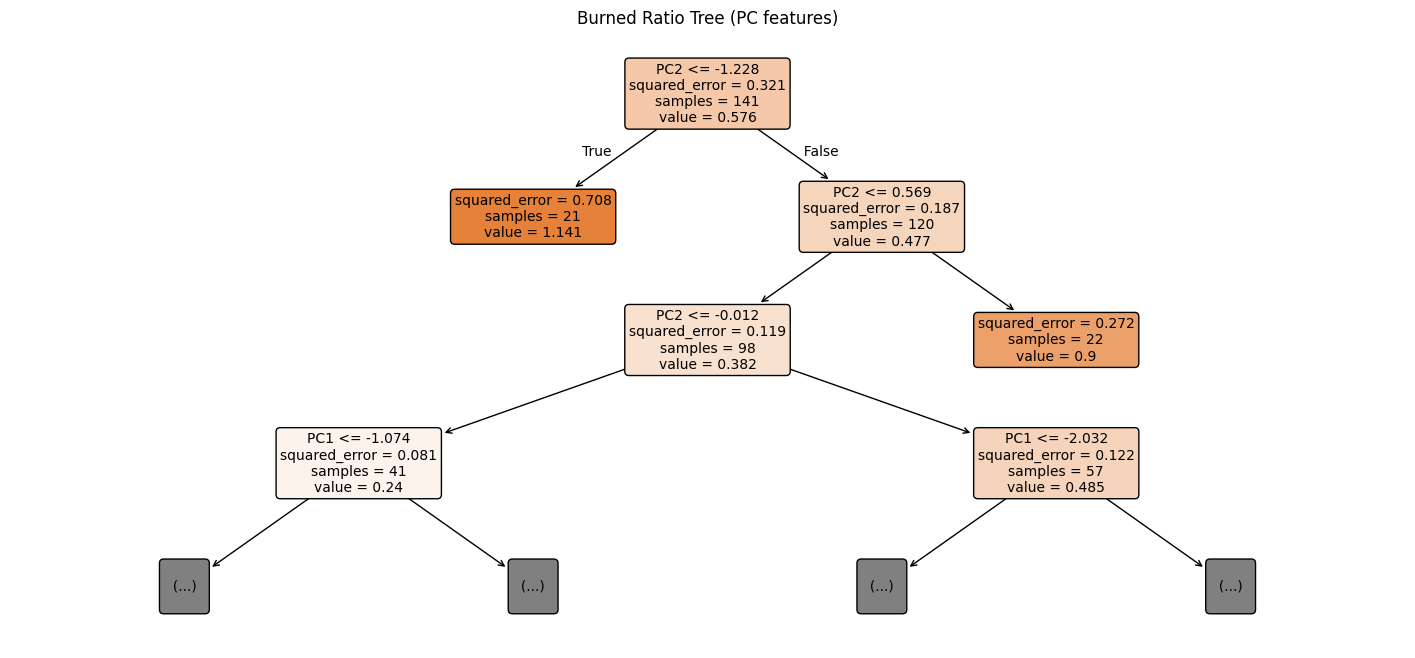

[PC FEATURES] fire_count (Train, log-scale) Metrics
RMSE: 0.6195
MAE: 0.4291
R2: 0.8530
[PC FEATURES] fire_count (Test, log-scale) Metrics
RMSE: 1.1077
MAE: 0.6877
R2: 0.6458
Best params (fire_count PC): {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}


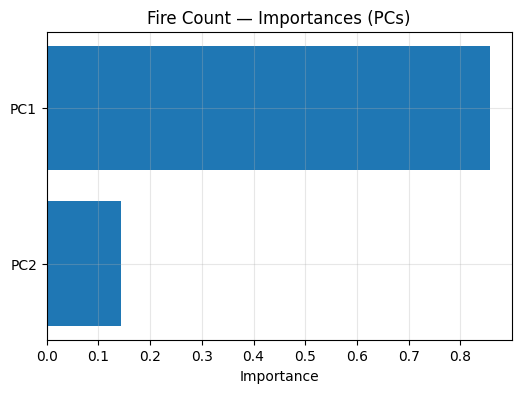

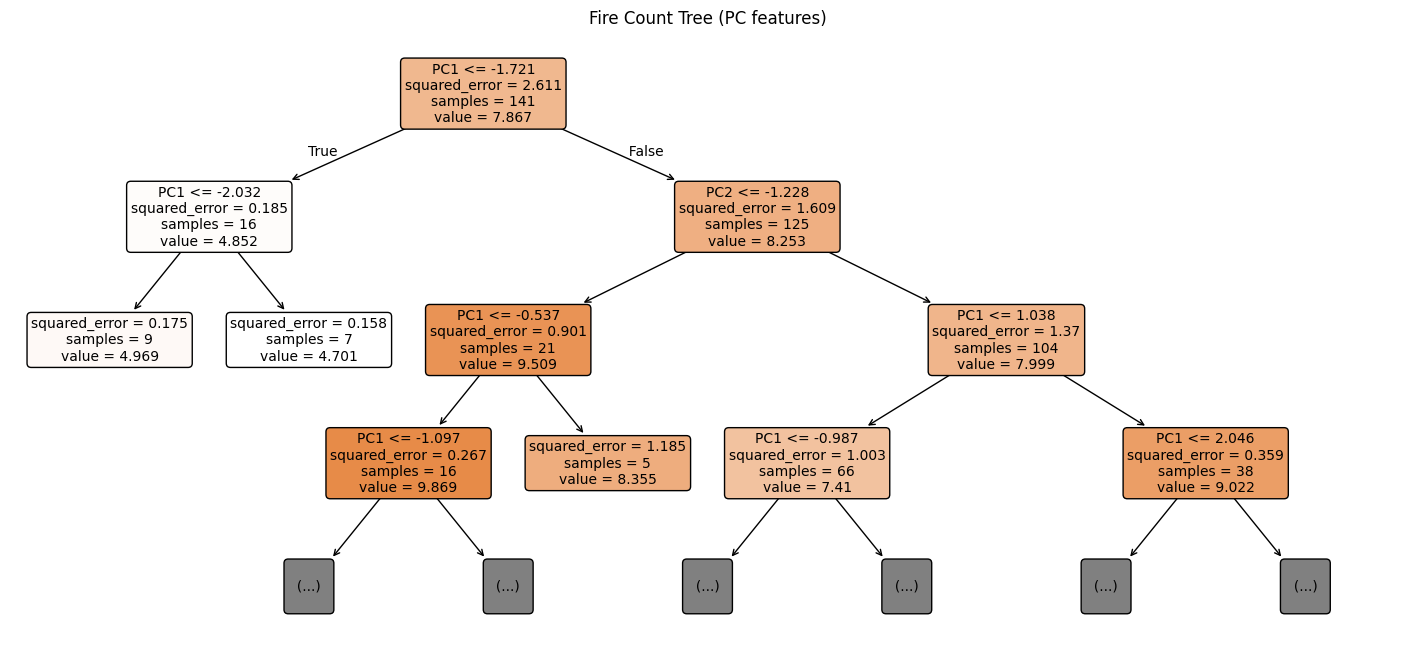

In [50]:
#Using PCs rather than row data
PC_FEATURES = ["PC1", "PC2"]

df_pca_ml = scoresDF.dropna(subset=PC_FEATURES + ["burned_ratio","fire_count"]).copy()

# Burned Ratio with PCs
burn_pc = fit_tree_for_target(df_pca_ml, "burned_ratio", PC_FEATURES, title_prefix="[PC FEATURES] ")
print("Best params (burned_ratio PC):", burn_pc["best_params"])
plot_feature_importance(burn_pc["best_model"], PC_FEATURES, "Burned Ratio — Importances (PCs)")
plot_decision_tree(burn_pc["best_model"], PC_FEATURES, "Burned Ratio Tree (PC features)", max_depth=3)

# Fire count with PCs
fire_pc = fit_tree_for_target(df_pca_ml, "fire_count", PC_FEATURES, title_prefix="[PC FEATURES] ")
print("Best params (fire_count PC):", fire_pc["best_params"])
plot_feature_importance(fire_pc["best_model"], PC_FEATURES, "Fire Count — Importances (PCs)")
plot_decision_tree(fire_pc["best_model"], PC_FEATURES, "Fire Count Tree (PC features)", max_depth=3)
